# Build Transformer Models for Bidirectional Translation Between English and French 
## Liu Yan 


>  The code below is adapted from the great breakdown by Alexander "Sasha" Rush ([@harvardnlp](https://twitter.com/harvardnlp)). It is a walkthrough for the paper ["Attention is All You Need"]
(https://arxiv.org/abs/1706.03762). The original notebook is no longer working due to compatibility issues and a few changes have been made to make it work and cater to the final project's needs.  


# Preparation

### Updated Code: Install Compatible Packages



In [1]:
# For PyTorch versions before 0.4.0, please use pip install torchtext==0.2.3.
!pip install -q torchtext==0.2.3
!pip install -q fastai==0.7.0
!pip install torchvision==0.1.9
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
#!pip install numpy matplotlib spacy torchtext 

### Import Packages

In [0]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt


# Model Architecture

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder.

## Updated Code: Encoder and Decoder Stacks   
#### Add two methods encode and decode to prevent error



In [0]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(self.src_embed(src), src_mask)
        output = self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        return output
      
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


### Encoder: 

The encoder is composed of a stack of $N=6$ identical layers. 

In [0]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [0]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection [(cite)](he2016deep) around each of the two sub-layers, followed by layer normalization [(cite)](layernorm2016).  

In [0]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](srivastava2014dropout) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

In [0]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [0]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder:

The decoder is also composed of a stack of $N=6$ identical layers.  


In [0]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.  

In [0]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [0]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

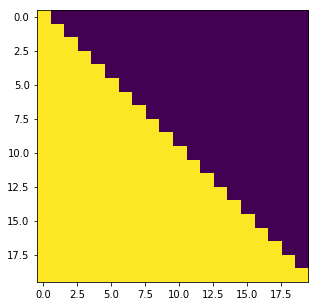

In [13]:
# The attention mask shows the position each tgt word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training. 
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### Attention:                                                                                                

In [0]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

### Multi-Head Attention                                                                           

In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Position-wise Feed-Forward Networks                                                                                                                                                                        

In [0]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax                                                                     

In [0]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding                                                                               

In [0]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))

  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

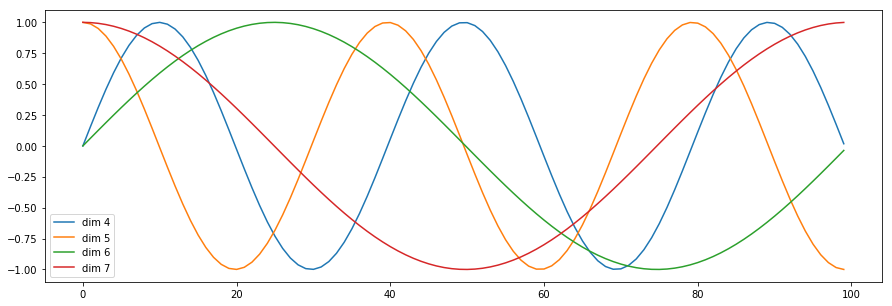

In [19]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

We also experimented with using learned positional embeddings [(cite)](JonasFaceNet2017) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.    

## Generation

In [0]:
class Generator(nn.Module):
    "Standard generation step. (Not described in the paper.)"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Full Model

In [0]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

# Training

This section describes the training regime for our models.


In [0]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask


In [0]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## Training Data and Batching

In [0]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)


## Optimizer      

In [0]:
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

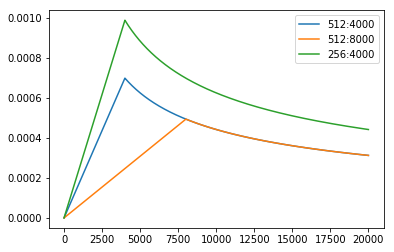

In [26]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## Regularization                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                                                      
### Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ [(cite)](DBLP:journals/corr/SzegedyVISW15).  
This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.  

In [0]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

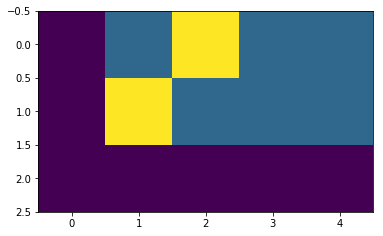

In [28]:
#Example
crit = LabelSmoothing(5, 0, 0.5)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

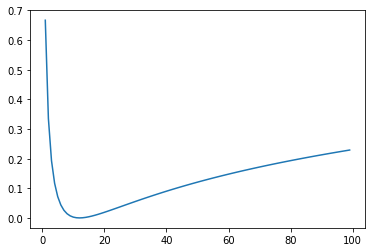

In [29]:
# Label smoothing starts to penalize the model 
# if it gets very confident about a given choice
crit = LabelSmoothing(5, 0, 0.2)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

### Memory Optimization

In [0]:
def loss_backprop(generator, criterion, out, targets, normalize):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.data[0]
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    out_grad = torch.stack(out_grad, dim=1)
    out.backward(gradient=out_grad)
    return total

In [0]:
def make_std_mask(src, tgt, pad):
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

### Updated Code: Increase Reporting nBatches from 10 to 100


In [0]:
def train_epoch(train_iter, model, criterion, opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
                        
        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 100 == 1:
            print(i, loss, model_opt._rate)

In [0]:
def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.test()
    total = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
        

In [0]:
class Batch:
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens
    
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())

# Load Data and Start Training

In [0]:
from torchtext import data, datasets

In [35]:
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download de
!python -m spacy download fr

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')



## Updated Code: Translate From French to English 
Original code translated from German to English



In [0]:
# Load words from IWSLT

#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

import spacy
#spacy_de = spacy.load('de')
spacy_en = spacy.load('en')
spacy_fr = spacy.load('fr')

def tokenize_fr(text):
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field(tokenize=tokenize_fr, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                 eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100
train, val, test = datasets.IWSLT.splits(exts=('.fr', '.en'), fields=(SRC, TGT), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 1
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

In [0]:
# Detail. Batching seems to matter quite a bit. 
# This is temporary code for dynamic batching based on number of tokens.
# This code should all go away once things get merged in this library.

BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

### Show Model Summary

In [39]:
# Create the model and load it onto our GPU.
pad_idx = TGT.vocab.stoi["<blank>"]
model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
model_opt = get_std_opt(model)
model.cuda()

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:89: UserWarning: 
    Found GPU0 Tesla T4 which requires CUDA_VERSION >= 8000 for
     optimal performance and fast startup time, but your PyTorch was compiled
     with CUDA_VERSION 8000. Please install the correct PyTorch binary
     using instructions from http://pytorch.org
    
  warnings.warn(error_str % (d, name, 8000, CUDA_VERSION))


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512)
            (1): Linear(in_features=512, out_features=512)
            (2): Linear(in_features=512, out_features=512)
            (3): Linear(in_features=512, out_features=512)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048)
          (w_2): Linear(in_features=2048, out_features=512)
          (dropout): Dropout(p=0.1)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
          (1): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
        )
      )
      (1): EncoderLayer(
        (self_attn): MultiH

### Decrease Training Ephochs from 15 to 3
Add try-exception to catch a weird error



In [40]:

criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
for i, epoch in zip(range(3),range(3)):
    try: 
        print("Epoch", i+1)
        train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
        valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)
    except:
      pass

Epoch 1
1 9.5057203322649 6.987712429686844e-07
101 8.570706175640225 3.56373333914029e-05
201 6.254039419582114 7.057589553983712e-05
301 5.2729468531906605 0.00010551445768827134
401 5.129672376438975 0.00014045301983670557
501 4.92047338525299 0.00017539158198513977
601 4.924300765937005 0.000210330144133574
701 4.673353085687268 0.00024526870628200823
801 4.531137476937147 0.0002802072684304424
901 4.096565066371113 0.00031514583057887664
1001 4.7376276087306906 0.0003500843927273108
1101 4.324538130167639 0.0003850229548757451
1201 4.460166577875498 0.0004199615170241793
Epoch 2
1 3.575336290989071 0.00045000868047183275
101 3.8148429293705703 0.0004849472426202669
201 3.0997549731473555 0.0005198858047687012
301 3.459280114271678 0.0005548243669171353
401 3.1222199423937127 0.0005897629290655697
501 2.027361011132598 0.0006247014912140038
601 3.4021986243897118 0.000659640053362438
701 3.382086129813615 0.0006945786155108723
801 2.8558721793815494 0.0007295171776593065
901 1.9760

### Comment
In 3 epochs, the loss continues to decrease and the optimized learning rate gradually increases from e-07 to e-03

## Updated Code: Translate from English to French

In [0]:
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"

TGT_fr = data.Field(tokenize=tokenize_fr, pad_token=BLANK_WORD)
SRC_en = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                    eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100
train_en_fr, val_en_fr, test_en_fr = datasets.IWSLT.splits(
                                         exts=('.en', '.fr'), 
                                         fields=(SRC_en, TGT_fr), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 1
SRC_en.build_vocab(train_en_fr.src, min_freq=MIN_FREQ)
TGT_fr.build_vocab(train_en_fr.trg, min_freq=MIN_FREQ)

In [0]:
# Detail. Batching seems to matter quite a bit. 
# This is temporary code for dynamic batching based on number of tokens.
# This code should all go away once things get merged in this library.

BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch

train_iter_en_fr = MyIterator(train_en_fr, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter_en_fr = MyIterator(val_en_fr, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

### Show Model Summary

In [76]:
# Create the model and load it onto our GPU.
pad_idx = TGT_fr.vocab.stoi["<blank>"]
model_en_fr = make_model(len(SRC_en.vocab), len(TGT_fr.vocab), N=6)
model_en_fr_opt = get_std_opt(model_en_fr)
model_en_fr.cuda()

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512)
            (1): Linear(in_features=512, out_features=512)
            (2): Linear(in_features=512, out_features=512)
            (3): Linear(in_features=512, out_features=512)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048)
          (w_2): Linear(in_features=2048, out_features=512)
          (dropout): Dropout(p=0.1)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
          (1): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
        )
      )
      (1): EncoderLayer(
        (self_attn): MultiH

### Decrease Training Epochs from 15 to 3

In [78]:

criterion = LabelSmoothing(size=len(TGT_fr.vocab), padding_idx=pad_idx, 
                           smoothing=0.1)
criterion.cuda()
for i, epoch in zip(range(3),range(3)):
    try: 
      print("Epoch", i+1)
      train_epoch((rebatch(pad_idx, b) for b in train_iter_en_fr), model_en_fr, 
                   criterion, model_en_fr_opt)
      valid_epoch((rebatch(pad_idx, b) for b in valid_iter_en_fr), model_en_fr, 
                  criterion)
    except:
      pass

Epoch 1
1 9.582306333817542 0.0012272608807124769
101 9.056958317756653 0.001215599072308045
201 9.401675701141357 0.0012042635107418354
301 9.271668612957 0.0011932392626943502
401 9.761919856071472 0.0011825123346139903
501 9.571456134319305 0.0011720695980213562
601 9.613771468400955 0.0011618987219440843
701 9.401271879673004 0.0011519881116914845
801 8.88751471042633 0.0011423268532777264
901 9.425382643938065 0.0011329046628878506
1001 9.746580334380269 0.0011237118408546165
1101 6.501348273828626 0.0011147392296779178
1201 9.409618027508259 0.0011059781756737072
1301 9.266793191432953 0.001097420493887318
Epoch 2
1 9.789507873356342 0.0010951437729029992
101 9.500893145799637 0.001086833258416229
201 9.71332137286663 0.0010787091105802038
301 9.195584744215012 0.0010707644663569482
401 8.95315170288086 0.0010629928114036086
501 9.179655969142914 0.0010553879576199693
601 8.646165706217289 0.0010479440224380409
701 8.980727016925812 0.0010406554096962018
801 9.842741597443819 0.0

### Comment
The loss at each step is significantly higher than when we train the model from English to French. The learning rate seems to fluctuate between 0.001 and 0.0009, which might be the reason for lack of any convergency in 3 epochs. This would lead to bad translation.

# Translation Examples

## Updated Code: Report BLEU score

### French to English

In [0]:
#from torch.autograd import Variable
#from .functional import subsequent_mask


def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(memory, src_mask, Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [70]:
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

def report_bleu(ref_tokens, result_tokens):
  smoothie = SmoothingFunction().method4
  print('Smoothed BLEU Score: {:.4f}'.format(corpus_bleu([ref_tokens],[result_tokens],smoothing_function=smoothie)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
ref_tokens = []
result_tokens = []
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi[BLANK_WORD]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, max_len=60, 
                        start_symbol=TGT.vocab.stoi[BOS_WORD])
    print('Translation:', end='\t')
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        result_tokens.append(sym)
        if sym == EOS_WORD:
            break
        print(sym, end=' ')
    print()
    print('Target:', end='\t')
    for i in range(batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        ref_tokens.append(sym)
        if sym == EOS_WORD:
            break
        print(sym, end=' ')
    print()
    report_bleu(ref_tokens,result_tokens)
    break

Translation:	Who does who puts a email email email a email ? 
Target:	<s> Who calls whom ? Who sends whom an email ? 
Smoothed BLEU Score: 0.2290


### English to French



In [87]:
ref_tokens = []
result_tokens = []
for i, batch in enumerate(valid_iter_en_fr):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC_en.vocab.stoi[BLANK_WORD]).unsqueeze(-2)
    out = greedy_decode(model_en_fr, src, src_mask, max_len=60, 
                        start_symbol=TGT_fr.vocab.stoi[BOS_WORD])
    print('Translation:', end='\t')
    for i in range(1, out.size(1)):
        sym = TGT_fr.vocab.itos[out[0, i]]
        result_tokens.append(sym)
        if sym == EOS_WORD:
            break
        print(sym, end=' ')
    print()
    print('Target:', end='\t')
    for i in range(batch.trg.size(0)):
        sym = TGT_fr.vocab.itos[batch.trg.data[i, 0]]
        ref_tokens.append(sym)
        if sym == EOS_WORD:
            break
        print(sym, end=' ')
    print()
    report_bleu(ref_tokens,result_tokens)
    break

Translation:	Etes maison-mère composaient avion-fusée internaliser traitements lontemps Phoques sclérosent bardeaux provocante hydrothermaux Théière Reilly Lauralee extra-terrestres thaïs direz vulgaire direz hydrothermaux direz Astronomie expédiées immunologistes Day bardeaux direz Enlevés Phoques Théière grimaces direz grimaces aryens lontemps hydrothermaux avion-fusée direz hydrothermaux bardeaux direz direz Théière direz aryens avion-fusée Day Théière direz direz Théière direz poisson&lt;br Day avion-fusée direz direz équivalence 
Target:	Au final , notre initiative a été adoptée et fut une réussite . <blank> <blank> <blank> <blank> <blank> 
Smoothed BLEU Score: 0.0000


### Comment



While the translation from French to English is decent, the translation from English to French with the same data source, is unacceptable. We can tell this directly from the BLEU score.  


# Summary

1.   Keeping packages in use compatible with each other requires essential consideration when writing code. 
Package versions must be detaily documented. 
2.   While the idea to test the quality of the translation by training two modesl to translate back and forth is interesting, to fully explore the potential effects would require a good grasp of appropriate data.
3.  Learning rate must be wisely chosen (such as in the case of translating from French to English) and the best learning rate may not be universal (such as in the case of translating from English to French). A different optimization algorithm might be necessary to further improve the Englisht-to-French language model. 
4. BLEU score is still a good indicator for translation quality.

